<a href="https://colab.research.google.com/github/rohan260696/CE888-LAB-Solutions-/blob/master/CE888%20PROJECT/CE888_PRJ_BUILD_EXPERT_ITERATION_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXPERT ITERATION MODEL**

## DATASET FRAMEWORK

In [0]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from math import *
import random
import numpy as np
import statistics
from scipy.stats import linregress

def create_framework():
    ''' Create dataset Framework,
    or reset data to default empty 
    state to ready it for next iteration
    ''' 
    
    global data

    data = {
            'State0':[],
            'State1':[],
            'State2':[],
            'State3':[],
            'State4':[],
            'State5':[],
            'State6':[],
            'State7':[],
            'State8':[],
            'Player':[],
            'Move'  :[]
            }

    return data

def create_dataset(data):
  ''' creates a pandas dataframe when passed with data   
  Takes 1 arguments data -- type dict'''

  dataset = pd.DataFrame(data, columns= ('State0','State1','State2','State3','State4','State5','State6','State7','State8','Player','Move'))
 
  return dataset


## GAME MECHANICS

In [0]:

class GameState:
    """ A state of the game, i.e. the game board. These are the only functions which are
        absolutely necessary to implement UCT in any 2-player complete information deterministic 
        zero-sum game, although they can be enhanced and made quicker, for example by using a 
        GetRandomMove() function to generate a random move during rollout.
        By convention the players are numbered 1 and 2.
    """
    def __init__(self):
            self.playerJustMoved = 2 # At the root pretend the player just moved is player 2 - player 1 has the first move
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = GameState()
        st.playerJustMoved = self.playerJustMoved
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerJustMoved.
        """
        self.playerJustMoved = 3 - self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """

    def __repr__(self):
        """ Don't need this - but good style.
        """
        pass


In [0]:
class OXOState:
    """ A state of the game, i.e. the game board.
        Squares in the board are in this arrangement
        012
        345
        678
        where 0 = empty, 1 = player 1 (X), 2 = player 2 (O)
    """
    def __init__(self):
        self.playerJustMoved = 2 # At the root pretend the player just moved is p2 - p1 has the first move
        self.board = [0,0,0,0,0,0,0,0,0] # 0 = empty, 1 = player 1, 2 = player 2
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = OXOState()
        st.playerJustMoved = self.playerJustMoved
        st.board = self.board[:]
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerToMove.
        """
        assert move >= 0 and move <= 8 and move == int(move) and self.board[move] == 0
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        return [i for i in range(9) if self.board[i] == 0]
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """
        for (x,y,z) in [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]:
            if self.board[x] == self.board[y] == self.board[z]:
                if self.board[x] == playerjm:
                    return 1.0
                else:
                    return 0.0
        if self.GetMoves() == []: return 0.5 # draw
        return False # Should not be possible to get here

    def __repr__(self):
        s= ""
        for i in range(9): 
            s += ".XO"[self.board[i]]
            if i % 3 == 2: s += "\n"
        return s


In [0]:
class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result

    def __repr__(self):
        return "[M:" + str(self.move) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s


In [0]:

def UCT(rootstate, itermax, player, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""
    
   # print("UCT BEGINS")

    rootnode = Node(state = rootstate)
 
    for i in range(itermax):
   
       # print("UCTS ITER",i)
   
        node = rootnode
        state = rootstate.Clone()

        # Select
   
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
   
        #    print("SELECT")
   
            node = node.UCTSelectChild()
            state.DoMove(node.move)
   
         #   print('Move done by select', node.move)

       # Expand
  
        if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
  
          #  print("EXPAND")
  
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m, state)  # add child and descend tree
  
          # print('Move done by expand', m )

      # Rollout/Simulation - this can often be made orders of magnitude quicker using a state.GetRandomMove() function 
        
        while state.GetMoves() != []: # while state is non-terminal
            
            #print("ROLLOUT")
            
            cur_state = state.board + [3-state.playerJustMoved]
            key = [1,2]
            
            #print('Cur state in rollout',cur_state)
            #print("CLassifier prediction", player.predict(np.reshape(cur_state,[1,-1]))[0])
            
            if(random.choices(key,weights = [0.9,0.1])[0] == 1):
                   
                    if(player.predict(np.reshape(cur_state,[1,-1]))[0] in state.GetMoves()):
            
              #          print(' knn classifier predicts next move for rollout')
            
                        state.DoMove(player.predict(np.reshape(cur_state,[1,-1]))[0])
            
                    else:
            
              #          print(' Random move for rollout since predicted move illegal')
            
                        state.DoMove(random.choice(state.GetMoves()))
            
            else:
            
                state.DoMove(random.choice(state.GetMoves()))
            
               # print(' Random move for rollout 10 % of time ')

        # Backpropagate
        
        while node != None: # backpropagate from the expanded node and work back to the root node
        
            #print("BACKPROPOGATE")
        
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

   # Output some information about the tree - can be omitted
   # if verbose: print(rootnode.TreeToString(0))
   # else: print(rootnode.ChildrenToString())

    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited
                

In [0]:
def UCTPlayGame(agent1, agent2):
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """

    #print("BEGIN")

    state = OXOState() # uncomment to play OXO

    while state.GetMoves() != []:

     #   print("while available moves are not empty")

        x = str(state.board) ## captures the current state of the board
        x_  = str(state.board + [3-state.playerJustMoved]) 

      #  print('Actual state of the board',x_ )

        #print(data)

        data['State0'].append (x[1]) ## the following code breaks the data state (string) for board postions 0 to 8 
        data['State1'].append (x[4]) ## and stores it in the data dicitonary for generating dataset
        data['State2'].append (x[7])
        data['State3'].append (x[10])
        data['State4'].append (x[13])
        data['State5'].append (x[16])
        data['State6'].append (x[19])
        data['State7'].append (x[22])
        data['State8'].append (x[25])

        #print(str(state))

        if state.playerJustMoved == 1:

        #    print("player 2 turn")

            m = UCT(rootstate=state, itermax=50, player = agent2)  # play with values for itermax and verbose = True

        else:

        #    print("player 1 turn")

            m = UCT(rootstate=state, itermax=50, player = agent1)
       
        #    print("Best Move: " + str(m) + "\n")

        state.DoMove(m)
        
        data['Move'].append(m) # store the next move 
        data['Player'].append(state.playerJustMoved) # store the current player 

        if state.GetResult(state.playerJustMoved) != False:

         #   print(str(state))

            break
    
    if   state.GetResult(state.playerJustMoved) == 1.0:

        #print("Player " + str(state.playerJustMoved) + " wins!")

        return (str(state.playerJustMoved))

    elif state.GetResult(state.playerJustMoved) == 0.0:

        #print("Player " + str(3 - state.playerJustMoved) + " wins!")

        return (str(state.playerJustMoved))

    else: 

        #print("Nobody wins!")

        return ('T')    

## CLASSIFIER

In [0]:
clf = DecisionTreeClassifier(random_state = 42)

## TOURNAMENT ARRANGEMENT

In [0]:
def Tournament(agents,max_matches):
    '''
    Arrange a tournament between last agent vs all its previous agents
    
    Takes 2 arguments: 
        'agents' is a list of all the agents parciticapting in the tournament.
        'max_matches' is the maximum no of matches player 1 plays with player 2 
         finishing all the matches constitutes 1 round. 
    
    Last agent in the list is player 1, rest of the agents are player 2.
    Player 2 is cycled at the end of the round to the next agent in the list
    until there are no more agents.

    returns the win rate of Player 1 (last agent in the list)

    '''
    
    wins = 0 
    
    for agent in agents[:len(agents)-1]:
        for i in range(0,max_matches):
            if UCTPlayGame(agents[len(agents)-1], agent) == '1':
                wins = wins + 1
   
    win_rate =  (wins/((len(agents)-1) * max_matches))*100

    return win_rate


## ITERATION 

In [0]:
def ExpertIteration(iterations,games, max_matches):
    '''
    Perform Expert Iteration.
    
    Takes 3 arguments:
        'iterations' Total no of iterations of ExpertIteration Algorithm
        'games' Total no of games to be played to generate new data
        'max_matches' arguments to be passed to tournament, refers to the max
         matches a agent must play with another agent in a round
    
    returns None, plots result 
    '''
   
    agents = {'clf_0':None,'clf_1':None,'clf_2':None,
              'clf_3':None,'clf_4':None,'clf_5':None,
              'clf_6':None,'clf_7':None,'clf_8':None,
              'clf_9':None
              }

    keys = ['clf_0','clf_1','clf_2',
            'clf_3','clf_4','clf_5',
            'clf_6','clf_7','clf_8',
            'clf_9']
    i = 0
    iteration = []
    win_rates = []

    init_dataset = pd.read_csv('https://raw.githubusercontent.com/rohan260696/CE888-LAB-Solutions-/master/CE888%20PROJECT/CE888PROJECT_EXTENDED_DATASET.csv')
    Y,X = init_dataset.Move, init_dataset.drop(columns=['Move'])
    player = clf.fit(X,Y)

    #--EXPERT ITERATION--#

    while (i < iterations):
        
        print("\r",i, end = " ")

        #--COLLECT DATA--#

        data = create_framework()
        
        for games_played in range(0,games):
             UCTPlayGame(player, player) 
        
        dataset = pd.DataFrame(data, columns= ( 'State0','State1','State2',
                                                'State3','State4','State5',
                                                'State6','State7','State8',
                                                'Player','Move'))
        
        #--TRAINING--#
        
        Y,X = dataset.Move, dataset.drop(columns=['Move'])
        agents[keys[i%10]] = clf.fit(X,Y)
        player = agents[keys[i%10]] 
        
        #--PLAY TOURNAMENT--#

        if (i % 10 == 9):
            iteration.append(i+1)
            win_rates.append(Tournament(list(agents.values()),max_matches))

        #--UPDATE ITERATION--#

        i = i+1
    
    #--PLOT RESULTS--#
    
    plt.figure(1)
    plt.xlabel('Iteration')
    plt.ylabel('Win Percentage (%)')
    plt.plot(iteration,win_rates, marker = "o",color = "black",linestyle = 'dotted')
    
    mean = statistics.mean(win_rates)
    m = [mean] * len(iteration)
    plt.plot(iteration,m,linestyle = '--',color = 'red',label = 'Average Performance')
    
    z = np.polyfit(iteration, win_rates, 1)
    p = np.poly1d(z)
    plt.plot(iteration, p(iteration), 'm-',color = 'red',label = 'Performance Trend')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

    plt.savefig('Results')
    


 499 

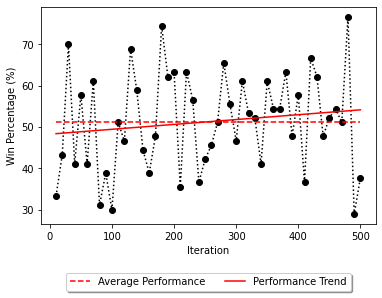

In [0]:
ExpertIteration(500,10,10)